## Neural tangent kernel

See https://www.inference.vc/neural-tangent-kernels-some-intuition-for-kernel-gradient-descent/ for details. That article explains how sensitive function values at locations $\mathbf{x}$ are to a prediction error at a *single* location $x'$. This is quantified by the *neural tangent kernel* $k_\theta({\mathbf{x}, x'})$ in the limit of infinitely wide neural networks and infinitesimally small gradient descent steps. In this limit, gradient descent can be understood as *kernel gradient descent* with a fixed kernel. 

The following example however uses much simpler models (`f_linear` and `f_rbf`), not infinitely wide neural networks. In this case, the kernel changes during optimization. The following example also visualizes how sensitive function values at locations $\mathbf{x}$ are to prediction errors at *multiple* locations $\mathbf{x}'$. I've mainly written this code to get a better initial understanding of the linked article. I still have to read further papers on this topic to get a deeper understanding, so please take everything in this notebook with a grain of salt.

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from jax import jacrev, jit, vmap

%matplotlib inline

In [2]:
def f_linear(theta, x):
    """Linear model."""
    return theta[0] * x + theta[1]


def f_rbf(theta, x):
    """Non-linear model with squared exponential basis functions."""    
    return theta[0] * jnp.exp(-((x - theta[1]) ** 2 / 30.0)) + \
           theta[2] * jnp.exp(-((x - theta[3]) ** 2 / 30.0)) + \
           theta[4]


f = f_rbf

In [3]:

@partial(jit, static_argnums=(0,))
def kernel_grad(f, theta, x_train, y_train, x_test, eta):
    """
    Computes kernel gradient of f under squared error loss.
    
    Returns a matrix that quantifies how sensitive function
    values at x_test are to prediction errors at x_train. Also
    returns updated parameters from a single gradient descent
    step (with learning rate eta).
    """
    
    # gradient of squared error loss w.r.t. theta
    l_grd = jacrev(lambda theta: jnp.square(y_train - f(theta, x_train)))
    # version of f that can be applied to multiple values of theta 
    f_map = vmap(lambda theta: f(theta, x_test))
    
    # gradient step per training example
    theta_step = eta * l_grd(theta)
    theta_new = theta - theta_step
    
    # overall gradient step
    theta_step_mean = jnp.mean(theta_step, axis=0)
    
    # Change in function values (#x_train, #x_test). Describes 
    # how sensitive function values at locations x_test are to 
    # prediction errors at locations x_train.
    k = (f_map(theta_new) - f(theta, x_test)) / eta

    return k, theta - theta_step_mean


def plot_change(f, theta, x_train, y_train, x_test, k, scale=100):
    plt.scatter(x_train, y_train, c='b');
    plt.plot(x_test, f(theta, x_test), c='b')
    plt.quiver(x_test, f(theta, x_test), jnp.zeros_like(x_test), jnp.sum(k, axis=0), color='r', scale=scale)

In [4]:
eta = 0.01

theta_0_linear = jnp.array([0.0, 0.0])
theta_0_rbf = jnp.array([4.0, -10.0, 25.0, 10.0, 50.0])

x_train = jnp.array([-3.0, 5.0, 10.0])
y_train = jnp.array([-12.0, 20.0, 50.0])

x_test = jnp.arange(-10.0, 20.0)

In [5]:
if f == f_linear:
    theta_0 = theta_0_linear
else:
    theta_0 = theta_0_rbf

In [6]:
# Initial step
k, theta = kernel_grad(f, theta_0, x_train, y_train, x_test, eta=eta)

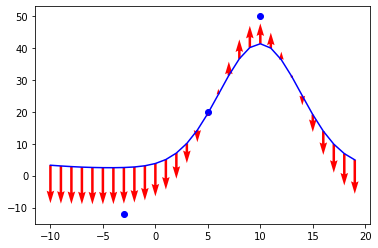

In [10]:
# -----------------------------------------
#  Run this cell repeatedly to see updates
# -----------------------------------------

plot_change(f, theta, x_train, y_train, x_test, k, scale=100)

for i in range(100):
    k, theta = kernel_grad(f, theta, x_train, y_train, x_test, eta=eta)